In [1]:
import itertools
import numpy as np
import scipy.stats
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import scipy
import itertools
project_dir = "E:\pirate_fmri\Analysis"
import sys
sys.path.append(project_dir)
from src.utils.composition_modelfit import *
from scipy.optimize import minimize
from joblib import Parallel,delayed,dump,load

## Model Space
**Key idea: modeling response as mixture models, i.e., coming from a range of x/y behaviour strategy combinations**

We define three behavourial strategies, each modelling response as a mixture of distributions:  
- **putative:&nbsp;**$p(response|putative) = (1-\alpha)*\mathcal{N}(putative,\sigma) +  \alpha*\mathcal{Uniform}(-r,r)$  
- **bias:&nbsp;**$p(response|putative) = (1-\alpha)*\mathcal{N}(bias,\sigma_{bias}) +  \alpha*\mathcal{Uniform}(-r,r)$   
- **random:&nbsp;** $response \sim Uniform(-r,r)$  where $r$ indicates current allowed range of response  
$\alpha$ is a lapse rate controlling the randomness of response

model can have different strategies for x and y axis, and they are combined using: $p(x|x_{strategy}) * p(y|y_{strategy})$  
Moreover, we assume there are certein degree of randomness in the overall response pattern, with is controlled by a 2D lapse rate $\beta$:
$$
    p(x,y|x_{strategy},y_{strategy}) = (1-\beta)*p(x|x_{strategy}) * p(y|y_{strategy}) + \beta * {1 \over ArenaArea}
$$

model can include a range of strategy combinations, and in each trial, response can be selected based on any of these strategy combinations.
Therefore the likelihood of each trial is:   
$$
    L_t = \sum_{k} ^{K} w_k*p(x,y|x_{strategy}^{k},y_{strategy}^{k})
$$

The objective function we are optimizing is:
$$\begin{aligned}
    \mathcal{NLL} &= \sum_{t} ^{T} NLL_t = -\sum_{t} ^{T} ln(L_t) \\
                  &= -\sum_{t} ^{T} ln(\sum_{k} ^{K} w_k*\left[(1-\beta)*p(x|x_{strategy}^{k}) * p(y|y_{strategy}^{k}) + \beta * {1 \over ArenaArea}\right])
\end{aligned}$$



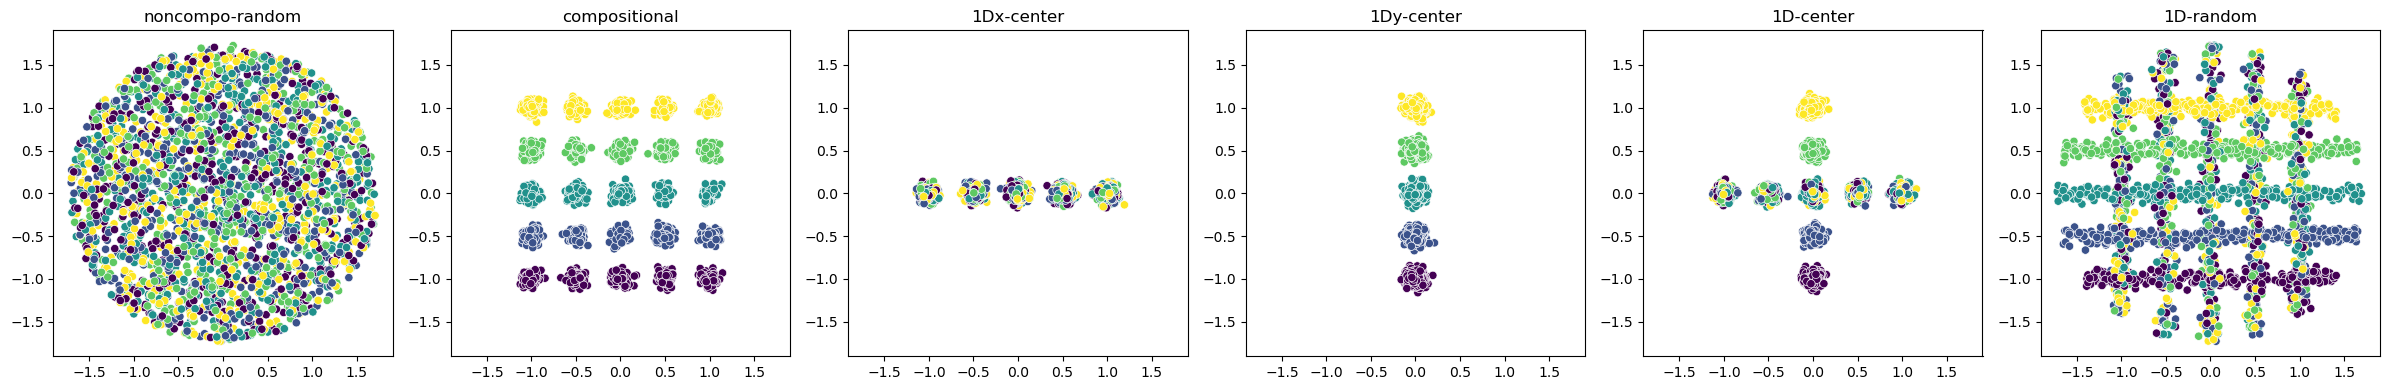

In [2]:
fakeds = (np.array(list(itertools.product(range(5),range(5))))-2)/2
fakeds = np.hstack([fakeds,fakeds])
def_param_dict = {
            "betax":1,"betay":1,
            "sigma_x":0.05,"sigma_y":0.05,
            "biasx":0,"biasy":0,
            "sigma_biasx":0.05,"sigma_biasy":0.05,
            "lapse_rate":0,
            "lapse_rate_2D":0.05
        }
model_param_dict = {
    "noncompo-random":def_param_dict,
    "compositional": def_param_dict,
    "1Dx-center":    def_param_dict,
    "1Dy-center":    def_param_dict,
    "1D-center":     def_param_dict,
    "1D-random":     def_param_dict
}
model_xystrategies = { # in the form of xstrategy-ystrategy
    "noncompo-random":["random-random"],
    "compositional": ["putative-putative"],
    "1Dx-center":["putative-bias"],
    "1Dy-center":["bias-putative"],
    "1D-center":["putative-bias","bias-putative"],
    "1D-random":["putative-random","random-putative"]
    }
arena_r = (5 + (1.42*60/53*1.1/2))*(2/6.8)
sample_size=1000
fig,axes = plt.subplots(1,len(model_xystrategies),figsize=(len(model_xystrategies)*4,4))
for j,mname in enumerate(model_xystrategies.keys()):
    currax = axes.flatten()[j]
    mstrategy = model_xystrategies[mname]
    mparam = model_param_dict[mname]
    predicted_resp = sample_response(mparam, mstrategy, fakeds,arena_r, sample_size=sample_size,seed=None)
    [sns.scatterplot(x = predicted_resp[k,0,:],y = predicted_resp[k,1,:],
                    c=fakeds[:,1],ax=currax) for k in range(100)]                
    currax.set_xlim([-1.1*arena_r,1.1*arena_r])
    currax.set_ylim([-1.1*arena_r,1.1*arena_r])
    currax.set_title(mname)
fig.tight_layout()

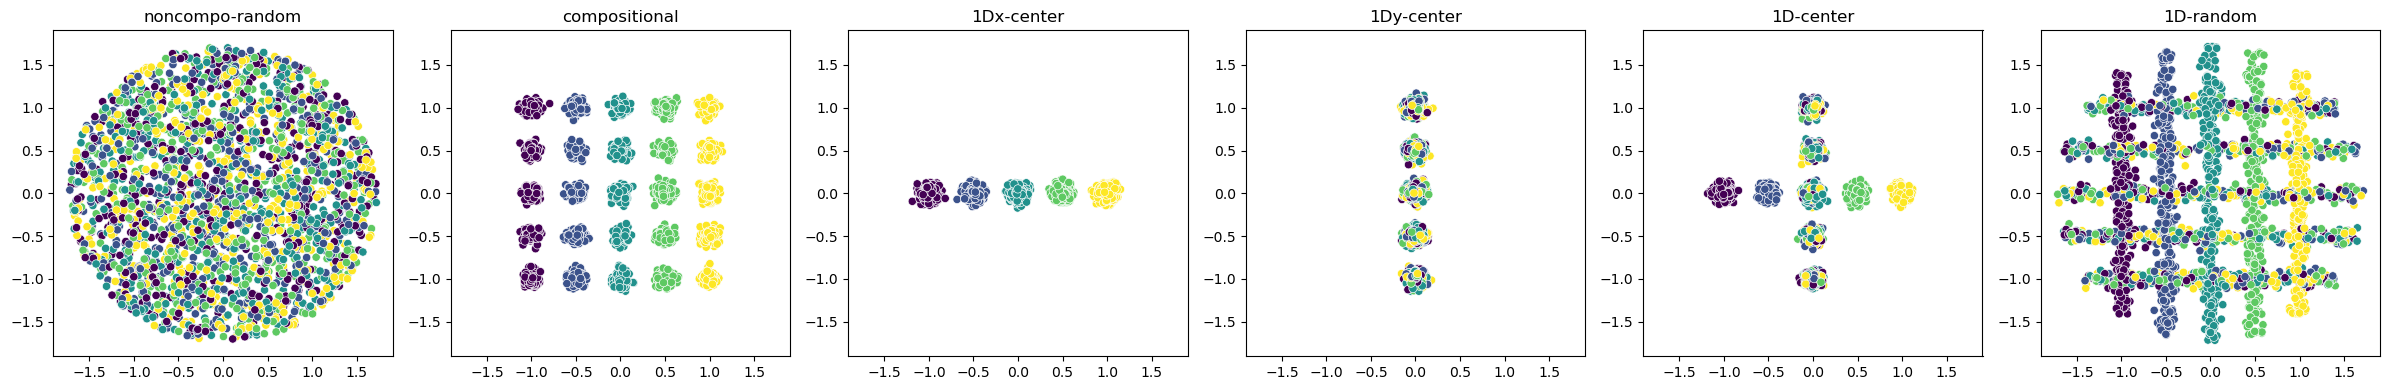

In [3]:
fakeds = (np.array(list(itertools.product(range(5),range(5))))-2)/2
fakeds = np.hstack([fakeds,fakeds])
def_param_dict = {
            "betax":1,"betay":1,
            "sigma_x":0.05,"sigma_y":0.05,
            "biasx":0,"biasy":0,
            "sigma_biasx":0.05,"sigma_biasy":0.05,
            "lapse_rate":0
        }
model_param_dict = {
    "noncompo-random":def_param_dict,
    "compositional": def_param_dict,
    "1Dx-center":    def_param_dict,
    "1Dy-center":    def_param_dict,
    "1D-center":     def_param_dict,
    "1D-random":     def_param_dict
}
model_xystrategies = { # in the form of xstrategy-ystrategy
    "noncompo-random":["random-random"],
    "compositional": ["putative-putative"],
    "1Dx-center":["putative-bias"],
    "1Dy-center":["bias-putative"],
    "1D-center":["putative-bias","bias-putative"],
    "1D-random":["putative-random","random-putative"]
    }
arena_r = (5 + (1.42*60/53*1.1/2))*(2/6.8)
sample_size=1000
fig,axes = plt.subplots(1,len(model_xystrategies),figsize=(len(model_xystrategies)*4,4))
for j,mname in enumerate(model_xystrategies.keys()):
    currax = axes.flatten()[j]
    mstrategy = model_xystrategies[mname]
    mparam = model_param_dict[mname]
    predicted_resp = sample_response(mparam, mstrategy, fakeds,arena_r, sample_size=sample_size,seed=None)
    [sns.scatterplot(x = predicted_resp[k,0,:],y = predicted_resp[k,1,:],
                    c=fakeds[:,0],ax=currax) for k in range(100)]                
    currax.set_xlim([-1.1*arena_r,1.1*arena_r])
    currax.set_ylim([-1.1*arena_r,1.1*arena_r])
    currax.set_title(mname)
fig.tight_layout()